In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. CHARGEMENT DES DONNÉES
# ========================================
df = pd.read_csv(
    r"C:\Users\MSI\Desktop\nlp\spam.csv",
    sep=";",
    encoding="latin-1"
)

# Renommer et garder seulement v1 et v2
df.rename(columns={0: 'v1', 1: 'v2'}, inplace=True)
df = df[['v1', 'v2']]

# Nettoyer la colonne v1 : enlever les guillemets triples
df['v1'] = df['v1'].str.strip()  # Enlever les espaces
df['v1'] = df['v1'].str.replace('"""', '', regex=False)  # Enlever """
df['v1'] = df['v1'].str.replace('"', '', regex=False)    # Enlever les "
df['v1'] = df['v1'].str.lower()  # Mettre en minuscules

print("="*50)
print("APERÇU DES DONNÉES")
print("="*50)
print(df.head())
print(f"\nNombre total d'exemples: {len(df)}")
print(f"Distribution des classes:\n{df['v1'].value_counts()}")
print(f"\nValeurs uniques dans v1: {df['v1'].unique()}")


APERÇU DES DONNÉES
     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Nombre total d'exemples: 5565
Distribution des classes:
v1
ham     4819
spam     746
Name: count, dtype: int64

Valeurs uniques dans v1: ['ham' 'spam']


In [7]:

# Assurer que v2 est string
df['v2'] = df['v2'].astype(str)

# Stopwords personnalisés
stop_words = set([
    'i','me','my','myself','we','our','ours','ourselves','you','your','yours',
    'yourself','yourselves','he','him','his','himself','she','her','hers','herself',
    'it','its','itself','they','them','their','theirs','themselves','what','which',
    'who','whom','this','that','these','those','am','is','are','was','were','be','been',
    'being','have','has','had','having','do','does','did','doing','a','an','the','and',
    'but','if','or','because','as','until','while','of','at','by','for','with','about',
    'against','between','into','through','during','before','after','above','below','to',
    'from','up','down','in','out','on','off','over','under','again','further','then',
    'once','here','there','when','where','why','how','all','any','both','each','few',
    'more','most','other','some','such','no','nor','not','only','own','same','so','than',
    'too','very','s','t','can','will','just','don','should','now'
])

In [9]:
# 1️⃣ Lowercase
df['v2_lower'] = df['v2'].str.lower()

# 2️⃣ Remove punctuation
df['v2_nopunct'] = df['v2_lower'].str.translate(str.maketrans('', '', string.punctuation))

# 3️⃣ Tokenization simple (split sur espaces)
df['v2_tokens'] = df['v2_nopunct'].str.split()

# 4️⃣ Stopwords removal
df['v2_nostop'] = df['v2_tokens'].apply(lambda tokens: [w for w in tokens if w not in stop_words])

# 5️⃣ Stemming (ajouté après stopwords)
stemmer = PorterStemmer()
df['v2_stemmed'] = df['v2_nostop'].apply(lambda tokens: [stemmer.stem(w) for w in tokens])

In [11]:
# 6️⃣ Reconvertir en texte pour TF-IDF
df['v2_processed'] = df['v2_stemmed'].apply(lambda tokens: ' '.join(tokens))

# 7️⃣ Word indexing (pour référence, pas utilisé directement dans TF-IDF)
all_words = set(w for tokens in df['v2_stemmed'] for w in tokens)
word_to_index = {word: idx+1 for idx, word in enumerate(sorted(all_words))}
df['v2_indexed'] = df['v2_stemmed'].apply(lambda tokens: [word_to_index[w] for w in tokens])

print("Étapes de preprocessing appliquées:")
print("✓ 1. Lowercasing")
print("✓ 2. Remove punctuation")
print("✓ 3. Tokenization")
print("✓ 4. Stop words removal")
print("✓ 5. Stemming (Porter)")
print("✓ 6. Word indexing")

print("\nExemple de preprocessing:")
print(f"Original:     {df['v2'].iloc[0]}")
print(f"Lowercase:    {df['v2_lower'].iloc[0]}")
print(f"No punct:     {df['v2_nopunct'].iloc[0]}")
print(f"Tokens:       {df['v2_tokens'].iloc[0]}")
print(f"No stopwords: {df['v2_nostop'].iloc[0]}")
print(f"Stemmed:      {df['v2_stemmed'].iloc[0]}")
print(f"Processed:    {df['v2_processed'].iloc[0]}")
print(f"Indexed:      {df['v2_indexed'].iloc[0][:10]}...")  # Afficher 10 premiers indices

Étapes de preprocessing appliquées:
✓ 1. Lowercasing
✓ 2. Remove punctuation
✓ 3. Tokenization
✓ 4. Stop words removal
✓ 5. Stemming (Porter)
✓ 6. Word indexing

Exemple de preprocessing:
Original:     Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Lowercase:    go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...
No punct:     go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
Tokens:       ['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
No stopwords: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
Stemmed:      ['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', '

In [13]:
# 3. TF-IDF VECTORIZATION
# ========================================
print("\n" + "="*50)
print("TF-IDF VECTORIZATION")
print("="*50)

# Créer le vectorizer TF-IDF
tfidf = TfidfVectorizer(
    max_features=3000,  # Limiter à 3000 features les plus importantes
    min_df=2,           # Ignorer les mots qui apparaissent dans moins de 2 documents
    max_df=0.8          # Ignorer les mots qui apparaissent dans plus de 80% des documents
)

# Transformer les textes en vecteurs TF-IDF
X = tfidf.fit_transform(df['v2_processed'])
print(f"Shape de la matrice TF-IDF: {X.shape}")
print(f"Nombre de features (mots): {len(tfidf.get_feature_names_out())}")

# Encoder les labels
le = LabelEncoder()
y = le.fit_transform(df['v1'])  # ham=0, spam=1
print(f"\nClasses encodées: {le.classes_}")
print(f"Distribution avant balancing:")
print(f"  Ham (0): {sum(y==0)} ({sum(y==0)/len(y)*100:.1f}%)")
print(f"  Spam (1): {sum(y==1)} ({sum(y==1)/len(y)*100:.1f}%)")


TF-IDF VECTORIZATION
Shape de la matrice TF-IDF: (5565, 3000)
Nombre de features (mots): 3000

Classes encodées: ['ham' 'spam']
Distribution avant balancing:
  Ham (0): 4819 (86.6%)
  Spam (1): 746 (13.4%)



BALANCING DES DONNÉES

📊 Méthode 1: Random Oversampling
Avant oversampling: 5565 exemples
Après oversampling: 9638 exemples
Distribution après oversampling:
  Ham (0): 4819 (50.0%)
  Spam (1): 4819 (50.0%)

📝 Méthode 2: Augmentation Textuelle
Classe minoritaire: spam (746 exemples)
Classe majoritaire: ham (4819 exemples)
Différence: 4073 exemples
Création de 6 versions augmentées par exemple minoritaire...
✓ 4073 exemples augmentés créés

Dataset final:
  Taille: 9638 exemples
  Ham: 4819 (50.0%)
  Spam: 4819 (50.0%)

🔄 Re-vectorisation TF-IDF sur dataset balancé...
Shape finale: (9638, 3000)


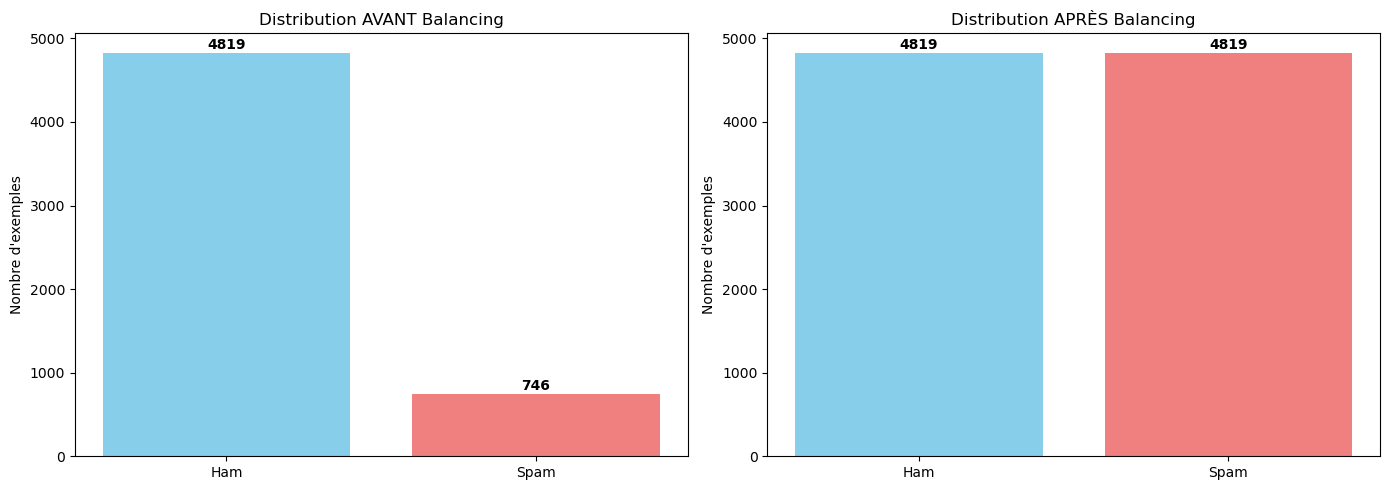

In [15]:
# 4. BALANCING DES DONNÉES (OVERSAMPLING + AUGMENTATION)
# ========================================
print("\n" + "="*50)
print("BALANCING DES DONNÉES")
print("="*50)

from imblearn.over_sampling import RandomOverSampler
import random

# Fonction d'augmentation textuelle
def augment_text(text, num_aug=1):
    """
    Augmente un texte en appliquant des transformations:
    - Synonym replacement (remplacement par synonymes simulé)
    - Random swap (échange de mots)
    - Random deletion (suppression aléatoire)
    """
    augmented_texts = []
    words = text.split()
    
    if len(words) < 3:  # Si texte trop court, juste le dupliquer
        return [text] * num_aug
    
    for _ in range(num_aug):
        aug_words = words.copy()
        
        # Technique 1: Random Swap (échanger 2 mots aléatoirement)
        if len(aug_words) > 1 and random.random() > 0.5:
            idx1, idx2 = random.sample(range(len(aug_words)), 2)
            aug_words[idx1], aug_words[idx2] = aug_words[idx2], aug_words[idx1]
        
        # Technique 2: Random Deletion (supprimer un mot avec prob 0.1)
        if len(aug_words) > 3:
            aug_words = [w for w in aug_words if random.random() > 0.1]
        
        # Technique 3: Duplication de mots importants (mots longs)
        if random.random() > 0.7:
            important_words = [w for w in aug_words if len(w) > 5]
            if important_words:
                word_to_duplicate = random.choice(important_words)
                aug_words.append(word_to_duplicate)
        
        augmented_texts.append(' '.join(aug_words))
    
    return augmented_texts

# Méthode 1: Random Oversampling avec SMOTE-like
print("\n📊 Méthode 1: Random Oversampling")
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(f"Avant oversampling: {X.shape[0]} exemples")
print(f"Après oversampling: {X_resampled.shape[0]} exemples")
print(f"Distribution après oversampling:")
print(f"  Ham (0): {sum(y_resampled==0)} ({sum(y_resampled==0)/len(y_resampled)*100:.1f}%)")
print(f"  Spam (1): {sum(y_resampled==1)} ({sum(y_resampled==1)/len(y_resampled)*100:.1f}%)")

# Méthode 2: Augmentation textuelle pour la classe minoritaire
print("\n📝 Méthode 2: Augmentation Textuelle")

# Identifier la classe minoritaire
minority_class = 1 if sum(y==1) < sum(y==0) else 0
majority_class = 1 - minority_class

minority_count = sum(y == minority_class)
majority_count = sum(y == majority_class)
diff = majority_count - minority_count

print(f"Classe minoritaire: {le.classes_[minority_class]} ({minority_count} exemples)")
print(f"Classe majoritaire: {le.classes_[majority_class]} ({majority_count} exemples)")
print(f"Différence: {diff} exemples")

# Créer des exemples augmentés pour la classe minoritaire
augmented_texts = []
augmented_labels = []

# Indices de la classe minoritaire
minority_indices = df[y == minority_class].index.tolist()

# Nombre d'augmentations par exemple
num_augmentations_needed = diff // len(minority_indices) + 1

print(f"Création de {num_augmentations_needed} versions augmentées par exemple minoritaire...")

for idx in minority_indices:
    original_text = df.loc[idx, 'v2_processed']
    
    # Générer des versions augmentées
    aug_versions = augment_text(original_text, num_aug=num_augmentations_needed)
    
    for aug_text in aug_versions:
        augmented_texts.append(aug_text)
        augmented_labels.append(minority_class)
    
    # Limiter pour ne pas trop dépasser
    if len(augmented_texts) >= diff:
        break

# Limiter au nombre exact nécessaire
augmented_texts = augmented_texts[:diff]
augmented_labels = augmented_labels[:diff]

print(f"✓ {len(augmented_texts)} exemples augmentés créés")

# Combiner les données originales avec les données augmentées
df_augmented = pd.DataFrame({
    'v2_processed': augmented_texts,
    'v1_encoded': augmented_labels
})

df_original = pd.DataFrame({
    'v2_processed': df['v2_processed'].values,
    'v1_encoded': y
})

df_balanced = pd.concat([df_original, df_augmented], ignore_index=True)

print(f"\nDataset final:")
print(f"  Taille: {len(df_balanced)} exemples")
print(f"  Ham: {sum(df_balanced['v1_encoded']==0)} ({sum(df_balanced['v1_encoded']==0)/len(df_balanced)*100:.1f}%)")
print(f"  Spam: {sum(df_balanced['v1_encoded']==1)} ({sum(df_balanced['v1_encoded']==1)/len(df_balanced)*100:.1f}%)")

# Re-vectoriser avec TF-IDF sur le dataset balancé
print("\n🔄 Re-vectorisation TF-IDF sur dataset balancé...")
X_balanced = tfidf.fit_transform(df_balanced['v2_processed'])
y_balanced = df_balanced['v1_encoded'].values

print(f"Shape finale: {X_balanced.shape}")

# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Avant balancing
axes[0].bar(['Ham', 'Spam'], [sum(y==0), sum(y==1)], color=['skyblue', 'lightcoral'])
axes[0].set_title('Distribution AVANT Balancing')
axes[0].set_ylabel('Nombre d\'exemples')
for i, v in enumerate([sum(y==0), sum(y==1)]):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Après balancing
axes[1].bar(['Ham', 'Spam'], 
           [sum(df_balanced['v1_encoded']==0), sum(df_balanced['v1_encoded']==1)], 
           color=['skyblue', 'lightcoral'])
axes[1].set_title('Distribution APRÈS Balancing')
axes[1].set_ylabel('Nombre d\'exemples')
for i, v in enumerate([sum(df_balanced['v1_encoded']==0), sum(df_balanced['v1_encoded']==1)]):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Utiliser les données balancées pour la suite
X = X_balanced
y = y_balanced

In [17]:
# 5. TRAIN/VALIDATION/TEST SPLIT
# ========================================
print("\n" + "="*50)
print("SPLIT DES DONNÉES BALANCÉES")
print("="*50)

# Split en Train (70%) et Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split Temp en Validation (15%) et Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train set: {X_train.shape[0]} exemples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} exemples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} exemples ({X_test.shape[0]/len(df)*100:.1f}%)")


SPLIT DES DONNÉES BALANCÉES
Train set: 6746 exemples (121.2%)
Validation set: 1446 exemples (26.0%)
Test set: 1446 exemples (26.0%)


In [19]:
# 6. MODEL TRAINING AVEC HYPERPARAMETER TUNING
# ========================================
print("\n" + "="*50)
print("TRAINING DES MODÈLES AVEC HYPERPARAMETER TUNING")
print("="*50)

# Dictionnaire pour stocker les résultats
results = {}

# -------- MODÈLE 1: NAIVE BAYES --------
print("\n1. Naive Bayes avec GridSearchCV...")
nb_params = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}

nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

nb_grid.fit(X_train, y_train)
print(f"Meilleurs paramètres NB: {nb_grid.best_params_}")
print(f"Meilleur score CV: {nb_grid.best_score_:.4f}")

results['Naive Bayes'] = {
    'model': nb_grid.best_estimator_,
    'train_score': nb_grid.score(X_train, y_train),
    'val_score': nb_grid.score(X_val, y_val),
    'cv_score': nb_grid.best_score_
}

# -------- MODÈLE 2: LOGISTIC REGRESSION --------
print("\n2. Logistic Regression avec GridSearchCV...")
lr_params = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    lr_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train, y_train)
print(f"Meilleurs paramètres LR: {lr_grid.best_params_}")
print(f"Meilleur score CV: {lr_grid.best_score_:.4f}")

results['Logistic Regression'] = {
    'model': lr_grid.best_estimator_,
    'train_score': lr_grid.score(X_train, y_train),
    'val_score': lr_grid.score(X_val, y_val),
    'cv_score': lr_grid.best_score_
}

# -------- MODÈLE 3: SVM --------
print("\n3. SVM avec GridSearchCV...")
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(
    SVC(random_state=42),
    svm_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train)
print(f"Meilleurs paramètres SVM: {svm_grid.best_params_}")
print(f"Meilleur score CV: {svm_grid.best_score_:.4f}")

results['SVM'] = {
    'model': svm_grid.best_estimator_,
    'train_score': svm_grid.score(X_train, y_train),
    'val_score': svm_grid.score(X_val, y_val),
    'cv_score': svm_grid.best_score_
}

# -------- MODÈLE 4: RANDOM FOREST --------
print("\n4. Random Forest avec GridSearchCV...")
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
print(f"Meilleurs paramètres RF: {rf_grid.best_params_}")
print(f"Meilleur score CV: {rf_grid.best_score_:.4f}")

results['Random Forest'] = {
    'model': rf_grid.best_estimator_,
    'train_score': rf_grid.score(X_train, y_train),
    'val_score': rf_grid.score(X_val, y_val),
    'cv_score': rf_grid.best_score_
}


TRAINING DES MODÈLES AVEC HYPERPARAMETER TUNING

1. Naive Bayes avec GridSearchCV...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleurs paramètres NB: {'alpha': 0.1}
Meilleur score CV: 0.9755

2. Logistic Regression avec GridSearchCV...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs paramètres LR: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleur score CV: 0.9951

3. SVM avec GridSearchCV...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Meilleur score CV: 0.9976

4. Random Forest avec GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs paramètres RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Meilleur score CV: 0.9923


In [21]:
print("COMPARAISON DES MODÈLES")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Accuracy': [results[m]['train_score'] for m in results],
    'Validation Accuracy': [results[m]['val_score'] for m in results],
    'CV Score (5-fold)': [results[m]['cv_score'] for m in results]
})

print(comparison_df.to_string(index=False))

# Trouver le meilleur modèle basé sur la validation
best_model_name = comparison_df.loc[comparison_df['Validation Accuracy'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 Meilleur modèle: {best_model_name}")

COMPARAISON DES MODÈLES
              Model  Train Accuracy  Validation Accuracy  CV Score (5-fold)
        Naive Bayes        0.985918             0.979253           0.975540
Logistic Regression        1.000000             0.994467           0.995108
                SVM        1.000000             0.998617           0.997628
      Random Forest        1.000000             0.993776           0.992292

🏆 Meilleur modèle: SVM



ÉVALUATION FINALE SUR TEST SET - SVM

Test Accuracy: 0.9986

Classification Report:
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       723
        spam       1.00      1.00      1.00       723

    accuracy                           1.00      1446
   macro avg       1.00      1.00      1.00      1446
weighted avg       1.00      1.00      1.00      1446



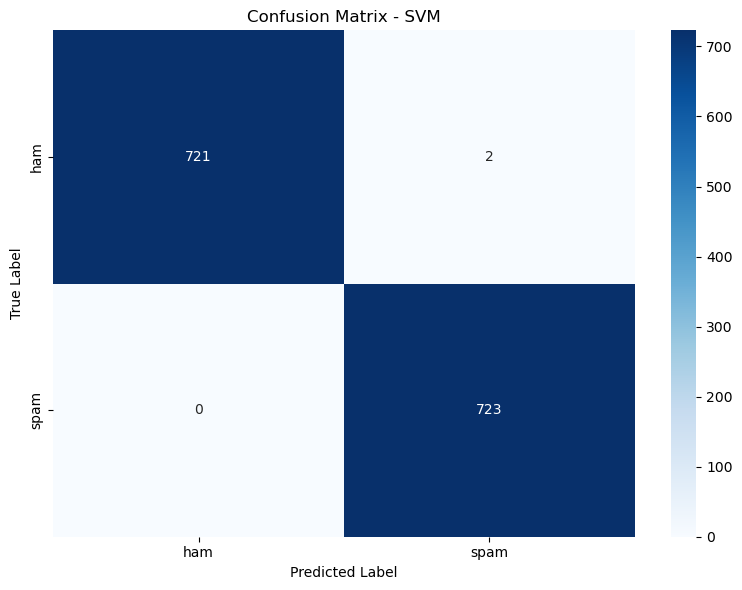

In [23]:
print("\n" + "="*50)
print(f"ÉVALUATION FINALE SUR TEST SET - {best_model_name}")
print("="*50)

y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


VISUALISATION DES RÉSULTATS


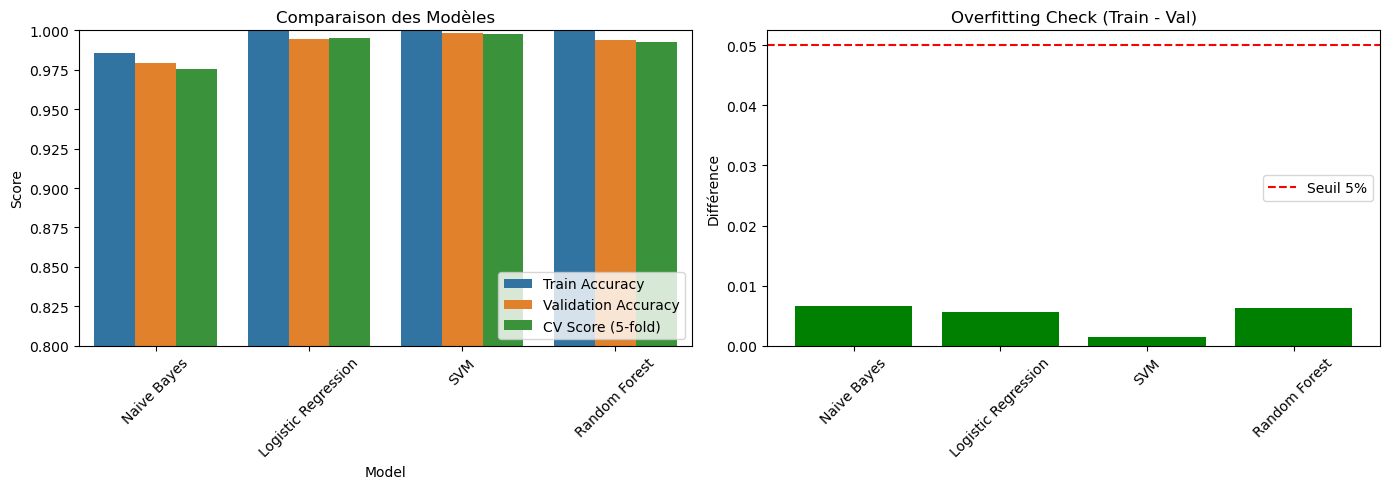


CROSS-VALIDATION DÉTAILLÉE (10-FOLD)

Cross-validation scores (10-fold): [0.99407407 1.         1.         1.         0.99851852 1.
 0.99703264 0.99554896 0.99703264 0.99406528]
Mean CV Score: 0.9976 (+/- 0.0046)


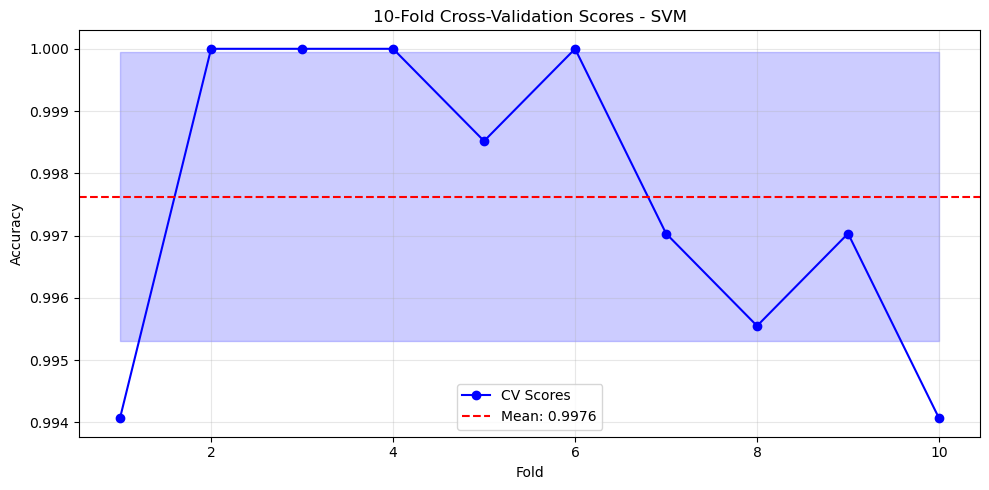


PIPELINE TERMINÉ ✓


In [25]:
print("\n" + "="*50)
print("VISUALISATION DES RÉSULTATS")
print("="*50)

# Graphique de comparaison
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Comparaison des accuracies
comparison_df_melted = comparison_df.melt(
    id_vars='Model', 
    value_vars=['Train Accuracy', 'Validation Accuracy', 'CV Score (5-fold)'],
    var_name='Metric', 
    value_name='Score'
)

sns.barplot(data=comparison_df_melted, x='Model', y='Score', hue='Metric', ax=ax[0])
ax[0].set_title('Comparaison des Modèles')
ax[0].set_ylim(0.8, 1.0)
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(loc='lower right')

# Graphique 2: Overfitting check
overfitting = comparison_df['Train Accuracy'] - comparison_df['Validation Accuracy']
ax[1].bar(comparison_df['Model'], overfitting, color=['green' if x < 0.05 else 'orange' for x in overfitting])
ax[1].set_title('Overfitting Check (Train - Val)')
ax[1].set_ylabel('Différence')
ax[1].axhline(y=0.05, color='r', linestyle='--', label='Seuil 5%')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend()

plt.tight_layout()
plt.show()

# ========================================
# 10. CROSS-VALIDATION DÉTAILLÉE
# ========================================
print("\n" + "="*50)
print("CROSS-VALIDATION DÉTAILLÉE (10-FOLD)")
print("="*50)

cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')
print(f"\nCross-validation scores (10-fold): {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualisation des CV scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='-', color='b', label='CV Scores')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 11), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='b')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title(f'10-Fold Cross-Validation Scores - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("PIPELINE TERMINÉ ✓")
print("="*50)


In [33]:
nouveau_message = "Congratulations! You have won a free iPhone. Click here to claim it."

# Transformer le texte en vecteur
message_vect = tfidf.transform([nouveau_message])


In [35]:
prediction = best_model.predict(message_vect)

# Convertir le résultat en label lisible (ham ou spam)
predicted_label = le.inverse_transform(prediction)
print(f"Le message est classé comme : {predicted_label[0]}")


Le message est classé comme : spam


In [37]:
ham_message = "Hey John, are we still meeting for lunch tomorrow at 12:30?"
message_vect = tfidf.transform([ham_message])
prediction = best_model.predict(message_vect)

# Convertir le résultat en label lisible (ham ou spam)
predicted_label = le.inverse_transform(prediction)
print(f"Le message est classé comme : {predicted_label[0]}")




Le message est classé comme : ham
